# Project: Wrangling and Analyze Data

In [1]:
# importing library
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_archive=pd.read_csv("twitter-archive-enhanced.csv")

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"



In [ ]:
response=requests.get(url)

In [4]:
with open (url.split('/')[-1],mode= 'wb') as file:
    file.write (response.content)

In [4]:
df_image_prediction=pd.read_csv(url.split('/')[-1],sep="\t")

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
consumer_key = #api key
consumer_secret =  #api secret key
access_token = 
access_secret = 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [24]:
i=1
for t_id in df_archive.tweet_id:
    try:
        print(i)
        i+=1
        tweet= api.get_status(t_id)
        with open ("tweet_json.txt","a") as file_tweet:
            json.dump(tweet._json,file_tweet)
            file_tweet.write("\n")
        
    except: 
        print ("erreur pour la ligne {}".format(i))



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
erreur pour la ligne 21
21
22
23
24
25
26
27
28
erreur pour la ligne 29
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
erreur pour la ligne 97
97
98
99
100
101
102
erreur pour la ligne 103
103
104
105
erreur pour la ligne 106
106
107
108
109
110
111
112
113
114
115
116
117
118
119
erreur pour la ligne 120
120
121
122
123
124
125
126
127
128
129
130
131
132
133
erreur pour la ligne 134
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
erreur pour la ligne 157
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
erreur pour la ligne 184
184
185
186
erreur pour la ligne 187
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
erreur pour l

erreur pour la ligne 1617
1617
erreur pour la ligne 1618
1618
erreur pour la ligne 1619
1619
erreur pour la ligne 1620
1620
erreur pour la ligne 1621
1621
erreur pour la ligne 1622
1622
erreur pour la ligne 1623
1623
erreur pour la ligne 1624
1624
erreur pour la ligne 1625
1625
erreur pour la ligne 1626
1626
erreur pour la ligne 1627
1627
erreur pour la ligne 1628
1628
erreur pour la ligne 1629
1629
erreur pour la ligne 1630
1630
erreur pour la ligne 1631
1631
erreur pour la ligne 1632
1632
erreur pour la ligne 1633
1633
erreur pour la ligne 1634
1634
erreur pour la ligne 1635
1635
erreur pour la ligne 1636
1636
erreur pour la ligne 1637
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707

The "tweet_json.txt" is read line by line in a new data frame with the following data extracted: tweet_id, retweet count and favorite count

In [5]:
df_tweet=[]

In [6]:
i=1
with open("tweet_json.txt", encoding='utf-8') as file:
    while (file):
        print (i)
        tweet = file.readline()
        if (tweet == ""):
            break
        #tweet=tweet.replace('""','\'')
        tweet_json = json.loads(tweet)
        try:
            media_type=tweet_json["entities"]["media"][0]['type']
        except:
            media_type='no media'
        
        df_tweet.append({"id_tweet":tweet_json["id"],"retweet_count":tweet_json["retweet_count"],"favorite_count":tweet_json["favorite_count"],
                        "media_type":media_type})
        i+=1
  
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090


In [7]:
df_tweet= pd.DataFrame(df_tweet)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [8]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [9]:
df_image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [10]:
df_tweet

,id_tweet,retweet_count,favorite_count,media_type
0,892420643555336193,6975,33711,photo
1,892177421306343426,5276,29237,no media
2,891815181378084864,3466,21983,no media
3,891689557279858688,7197,36810,photo
4,891327558926688256,7721,35193,no media
...,...,...,...,...
2280,666049248165822465,36,88,photo
2281,666044226329800704,115,246,photo
2282,666033412701032449,36,100,photo
2283,666029285002620928,39,112,photo


In [11]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
df_archive.floofer.unique()

array(['None', 'floofer'], dtype=object)

In [14]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_tweet        2285 non-null   int64 
 1   retweet_count   2285 non-null   int64 
 2   favorite_count  2285 non-null   int64 
 3   media_type      2285 non-null   object
dtypes: int64(3), object(1)
memory usage: 71.5+ KB


In [15]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
df_image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
df_tweet.describe()

,id_tweet,retweet_count,favorite_count
count,2.285000e+03,2285.000000,2285.000000
mean,7.427441e+17,2471.562801,7074.228446
std,6.834014e+16,4176.422068,10986.734242
min,6.660209e+17,1.000000,0.000000
25%,6.776624e+17,491.000000,1192.000000
50%,7.204151e+17,1166.000000,3064.000000
75%,7.989340e+17,2870.000000,8743.000000
max,8.924206e+17,70379.000000,144334.000000


In [18]:
df_archive.duplicated().sum()

0

In [19]:
df_archive.tweet_id.duplicated().sum()

0

In [20]:
df_image_prediction.duplicated().sum()

0

In [21]:
df_image_prediction.tweet_id.duplicated().sum()

0

In [22]:
df_tweet.media_type.value_counts()

photo       1779
no media     506
Name: media_type, dtype: int64

In [43]:
df_archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

### Quality issues
1. Some dog's name are missing or invalid. Invalid dog's name are word that are not name but adverb, conjuction, etc. (for example: a, life, and) 

2. In the df_archive dataframe, some tweets have more than one dog_stage and it shouldn't be the case.

3. Timestamp column type is a string instead of datetime. 

4. There are rating denominator equal to 0, which is not a valid data. Denominator shouldn't be 0. 

5. Rating denominator's values are not uniformed. In another words, some are not equal to 10. If the denomanitor aren't uniform,  comparing the numerator is more tricky. 

6. In the dataframe, there are both tweet and retweet rows. However, we only need the tweet/

7. Some of the tweets don't have image. 

8. Some of the image are not of dog but other things. 



### Tidiness issues
1. Dog rating data tweet dispersed in 3 dataframe. 

2. In the tweet archive data frame: the dog stage is dispered in 4 columns instead of one. 





## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [23]:
# Make copies of original pieces of data
df_archive_clean = df_archive.copy()
df_image_prediction_clean = df_image_prediction.copy()
df_tweet_clean = df_tweet.copy()


### Issue #1: Timestamp column type is a string in the archive dataframe

#### Define: convert the timestamp column into datetime type

#### Code

In [24]:
df_archive_clean.timestamp=pd.to_datetime(df_archive_clean.timestamp,format="%Y-%m-%d %H:%M:%S +%f")

#### Test

In [25]:
df_archive_clean.timestamp.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2356 entries, 0 to 2355
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
2356 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 18.5 KB


### Issue #2: In the tweet archive data frame: the dog stage is dispered in 3 columns instead of one

#### Define: merge the columns doggo, floofer, pupper and puppo into one column named dog_stage

In this section, I will include the cleaning of another issue: double dog stage for one tweet. The reason is to have shorter and less time consuming code.

#### Code

In [26]:
df_archive_clean=pd.melt(df_archive_clean,id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name'], var_name='dog_stage_name',value_name='dog_stage')

In [27]:
df_archive_clean=df_archive_clean.drop('dog_stage_name',axis=1)

>Given that for some rows, the dog stage is missing, droping all the dog_stage equal to 'none' would lead to the loss the other row without dog_stage (missing dog_stage data). 
So, we will split the df_archive_clean into 2 dataframe: one with dog_stage and the second without. Then, we will append it, the dataframe with dog_stage at top. We will identify the duplicated tweet_id and drop out the corresponding row (given that the first instance are not marked as duplicated, row with dog_stage will be conserved).

In [28]:
df_archive_clean_with_DogStage=df_archive_clean.query('dog_stage != "None"')

In [29]:
df_archive_clean_no_DogStage=df_archive_clean.query('dog_stage == "None"')

>Like previously mentionned, for some tweets, there are more than one dog stage data. Which means that there will be duplicated tweet_id in the 'df_archive_clean_with_DogStage' data.frame. As there is no data helping to determine which one is the right stage, we can't just drop out the duplicated tweet_id. We have to clean those double dog stage first before continuing.

### Issue #3:  Cleaning the rows with double dog stage

#### Define: for duplicated tweet_id in the df_archive_clean_with_DogStage dataframe, convert the dog stage to None (missing value)

#### Code

In [30]:
tweet_id_duplucated =df_archive_clean_with_DogStage[df_archive_clean_with_DogStage.tweet_id.duplicated()].tweet_id

In [31]:
for id_dupl in tweet_id_duplucated:
    row_index = df_archive_clean_with_DogStage[df_archive_clean_with_DogStage["tweet_id"] ==id_dupl].index
    df_archive_clean_with_DogStage.loc[row_index,'dog_stage']='None'
    

#### Test

In [32]:
df_archive_clean_with_DogStage.query("tweet_id ==854010172552949760").dog_stage

200     None
2556    None
Name: dog_stage, dtype: object

> We have finished cleaning the issue #3, we are back to issue #2 

####  Back to Issue #2 code

The two dataframe are now combined back, the one with dog stage on top. 

In [33]:
df_archive_clean=pd.concat([df_archive_clean_with_DogStage,df_archive_clean_no_DogStage])

To drop out the excessive row, we can't just use the pd.drop_duplicates method because the dog_stage column sometimes differ. In this case, it is the duplicated_id that we are dropping.

In [34]:
df_archive_clean=df_archive_clean[- df_archive_clean.tweet_id.duplicated()]

#### Test

In [35]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 9 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [36]:
df_archive_clean.dog_stage.value_counts()

None       1990
pupper      245
doggo        83
puppo        29
floofer       9
Name: dog_stage, dtype: int64

### Issue #4: Dog rating data tweet dispersed in 3 dataframe 

#### Define: merge the three dataframe (df_archive_clean, df_tweet_clean, df_image_prediction) into one based on the tweet_id. 
Given that the number of rows in the dataframe are different, we will use the maximum tweet_id (outer), which can lead to missing value in some column. We have choose to do so to not miss any data. We will do the cleaning later.

#### Code

In [37]:
df_tweet_merge= df_archive_clean.merge(df_tweet_clean,how='outer',left_on='tweet_id', right_on= 'id_tweet')

In [38]:
df_tweet_merge=df_tweet_merge.merge(df_image_prediction_clean,how='outer',left_on='tweet_id', right_on= 'tweet_id')

We don't need the "id_tweet" column anymore, so we will drop it.

In [39]:
df_tweet_merge.drop("id_tweet",axis=1,inplace=True)

#### Test

In [40]:
df_tweet_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

> From now on, we will work with this combined dataframe.

### Issue #5: Missing or invalid dog name (for example: a,the)

#### Define: we can't do nothing with the missing name, so will keep it 'None'. For invalid name, we will change it into None (like the missing value). 
Invalid name are word that are name (for example: adverb, conjunction, etc.). It is remarked that invalid name start with a lowercase, we will use it to filter invalid name.

#### Code

In [44]:
index=df_tweet_merge[df_tweet_merge.name.str.islower() ].index

> let's see the invalid name

In [51]:
df_tweet_merge.loc[index,"name"].unique()

array(['just', 'one', 'his', 'a', 'mad', 'actually', 'all', 'the', 'such',
       'quite', 'not', 'incredibly', 'an', 'very', 'my', 'getting',
       'this', 'unacceptable', 'old', 'infuriating', 'by', 'officially',
       'life', 'light', 'space'], dtype=object)

In [52]:
df_tweet_merge.loc[index,"name"]="None"

#### Test

In [55]:
df_tweet_merge[df_tweet_merge.name.str.islower() ].name.value_counts

<bound method IndexOpsMixin.value_counts of Series([], Name: name, dtype: object)>

In [56]:
df_tweet_merge[df_tweet_merge.name.str.len()==2].name.value_counts()

Bo    9
Mo    1
Al    1
Ed    1
JD    1
Jo    1
Name: name, dtype: int64

### Issue #6: Rating denominator equal to 0 

#### Define: Change the rating denominator with 0 and the corresponding rating numerator into missing value: np.nan

#### Code

In [57]:
index=df_tweet_merge[df_tweet_merge.rating_denominator==0].index

In [58]:
df_tweet_merge.loc[index,"rating_denominator"]=np.nan

In [59]:
df_tweet_merge.loc[index,"rating_numerator"]=np.nan

#### Test

In [60]:
df_tweet_merge.rating_denominator.unique()

array([ 10.,  nan,  15.,  70.,   7.,  11., 150., 170.,  20.,  50.,  90.,
        80.,  40., 130., 110.,  16., 120.,   2.])

### Issue #7: Rating denominator's values vary

#### Define: standardize the denominator value equal to 10 and scale the corresponding numerator value accordingly. The result is then converted to int
Like this, it will be easier to compare the rating later

#### Code

In [62]:
scale=10/df_tweet_merge.rating_denominator

In [63]:
df_tweet_merge.loc[:,"rating_denominator"]=df_tweet_merge.rating_denominator*scale

In [64]:
df_tweet_merge.loc[:,"rating_numerator"]=df_tweet_merge.rating_numerator*scale

In [65]:
df_tweet_merge.loc[:,"rating_denominator"]=df_tweet_merge.rating_denominator.astype('Int64')
df_tweet_merge.loc[:,"rating_numerator"]=df_tweet_merge.rating_numerator.round().astype('Int64')

#### Test

In [66]:
df_tweet_merge.rating_denominator.value_counts()

10    2355
Name: rating_denominator, dtype: Int64

In [67]:
df_tweet_merge.rating_numerator.value_counts()

12      563
11      469
10      463
13      351
9       157
8       104
7        55
14       54
5        38
6        33
3        19
4        15
2        11
1         8
420       2
15        2
0         2
75        2
1776      1
17        1
34        1
182       1
666       1
27        1
26        1
Name: rating_numerator, dtype: Int64

### Issue #8: Tweet archive table contains both tweet and retweet 

#### Define: drop the row with retweet based on the retweeted_status_id columns
If it is not an original tweet but a retweet, the retweeted_status_id, retweeted_status_user_id,retweeted_status_timestamp columns, which refered to the original tweet informations, wouldn't be empty. In this case, we will use the retweeted_status_id columns to filter retweet from tweet. </br>
After taking out the retweet, we won't need the retweeted_status_id, retweeted_status_user_id,retweeted_status_timestamp columns anymore.

#### Code

In [73]:
index=df_tweet_merge[df_tweet_merge.retweeted_status_id.notnull()].index

In [74]:
df_tweet_merge.drop(index,axis=0,inplace=True)

#### Test

In [75]:
df_tweet_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2175 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2175 non-null   datetime64[ns]
 4   source                      2175 non-null   object        
 5   text                        2175 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2174 non-null   Int64         
 11  rating_denominator          2174 non-null   Int64       

> Dropping the 3 columns corresponding to retweet: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp  

In [76]:
df_tweet_merge.drop(["retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"],axis=1,inplace=True)

#### Test

In [77]:
df_tweet_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               2175 non-null   int64         
 1   in_reply_to_status_id  78 non-null     float64       
 2   in_reply_to_user_id    78 non-null     float64       
 3   timestamp              2175 non-null   datetime64[ns]
 4   source                 2175 non-null   object        
 5   text                   2175 non-null   object        
 6   expanded_urls          2117 non-null   object        
 7   rating_numerator       2174 non-null   Int64         
 8   rating_denominator     2174 non-null   Int64         
 9   name                   2175 non-null   object        
 10  dog_stage              2175 non-null   object        
 11  retweet_count          2125 non-null   float64       
 12  favorite_count         2125 non-null   float64       
 13  med

### Issue #9: Presence of tweet without image

#### Define: some tweets don't contain image, so we will drop those rows based the media_type and jgp_url column. If both jpg_url and media_type are missing for  a row, the tweet will be considered without image. Also, if the media_type is equal to "no media" and the jpg_url missing, it will be also considered without image.

#### Code

In [78]:
bool1=(df_tweet_merge.media_type=="no media") | (df_tweet_merge.media_type.isnull())
bool2=df_tweet_merge.jpg_url.isnull()

In [79]:
index=df_tweet_merge[bool1 & bool2].index

In [80]:
df_tweet_merge.drop(index,axis=0,inplace=True)

#### Test

In [81]:
df_tweet_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   int64         
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   object        
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_numerator       1994 non-null   Int64         
 8   rating_denominator     1994 non-null   Int64         
 9   name                   1994 non-null   object        
 10  dog_stage              1994 non-null   object        
 11  retweet_count          1950 non-null   float64       
 12  favorite_count         1950 non-null   float64       
 13  med

### Issue #10: Image without dog.

#### Define: drop row when the predicted image is not a dog

Given that we have the thre first prediction, we will use those three data to detected if there is a dog on the image or not. It is deduced that it is not a dog's image if the p1_dog, p2_dog and p3_dog columns are both false.

#### Code

In [82]:
not_dog = (df_tweet_merge.p1_dog== False) & (df_tweet_merge.p2_dog== False) & (df_tweet_merge.p3_dog== False)

In [83]:
index= df_tweet_merge[not_dog].index

In [84]:
df_tweet_merge.drop(index,axis=0,inplace=True)

#### Test

In [87]:
isdog = (df_tweet_merge.p1_dog== True) | (df_tweet_merge.p2_dog== True) | (df_tweet_merge.p3_dog== True)

In [89]:
isdog.value_counts()

True    1686
dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [90]:
df_tweet_merge.to_csv("twitter_archive_master.csv", index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In this section, we will analyse:
    <li>dog_rating data in general;</li>
    <li>dog_rating by dog_stage;</li>
    <li>relation between dog rating and favorite_count;</li>
    <li>favorite count and retweet count relationship. </li>

>Dog rating analysis: this is done by studying the numerator rating values and distribution within the dataframe, given that the denominator rating are the same.

In [91]:
df_tweet_merge.rating_numerator.describe()

count    1686.000000
mean       10.891459
std         2.506861
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        75.000000
Name: rating_numerator, dtype: float64

In [92]:
df_tweet_merge.rating_numerator.value_counts()

12    426
11    362
10    362
13    229
9     133
8      69
7      31
14     23
6      17
5      15
4       6
3       5
2       3
27      1
0       1
34      1
75      1
26      1
Name: rating_numerator, dtype: Int64

>Dog_rating analysis by dog_stage: the rating numerator data are studied for every dog stage. We don't considered the row without dog stage (Equal to None).

In [93]:
df_tweet_merge.groupby('dog_stage')['rating_numerator'].mean()

dog_stage
None       10.823816
doggo      11.925926
floofer         12.0
pupper     10.958333
puppo      11.952381
Name: rating_numerator, dtype: Float64

In [94]:
df_tweet_merge.groupby('dog_stage')['rating_numerator'].min()

dog_stage
None        0
doggo       8
floofer    10
pupper      7
puppo       9
Name: rating_numerator, dtype: Int64

In [95]:
df_tweet_merge.groupby('dog_stage')['rating_numerator'].max()

dog_stage
None       75
doggo      14
floofer    13
pupper     27
puppo      14
Name: rating_numerator, dtype: Int64

>Analysis of the relation between dog rating and favorite_count

In [96]:
df_tweet_merge.groupby('rating_numerator')['favorite_count'].mean()

rating_numerator
0     20908.000000
2      3033.666667
3      2844.400000
4      2346.166667
5      4504.400000
6      4657.411765
7      2000.700000
8      2330.647059
9      2091.740458
10     3365.988669
11     5718.731429
12    10023.258373
13    20429.562500
14    25653.260870
26     1572.000000
27     6181.000000
34     5041.000000
75    17326.000000
Name: favorite_count, dtype: float64

In [98]:
df_tweet_merge.groupby('rating_numerator')['favorite_count'].max()

rating_numerator
0      20908.0
2       4990.0
3       5984.0
4       4490.0
5      40060.0
6      33709.0
7      13589.0
8      32486.0
9      15498.0
10     70709.0
11     33012.0
12     80326.0
13    144334.0
14     82433.0
26      1572.0
27      6181.0
34      5041.0
75     17326.0
Name: favorite_count, dtype: float64

### Insights:
1. Dog rating analysis: in average,  rating vary from 0/10 to 75/10. The average rating is 10.89/10. But in general, rating are between 10 and 12;

2. There is no big difference in the average rating between the 4 dog stage. Pupper stage got the maximum rating and also the minimum if we don't take into account the missing dog stage value.

3. Dog with rating equals to 14 got the maximum average favorite counts. In general, rating and favorite counts are not proportional. 

### Visualization

We will plot the favorite_count against the retweet_count to see an eventual link between those two data

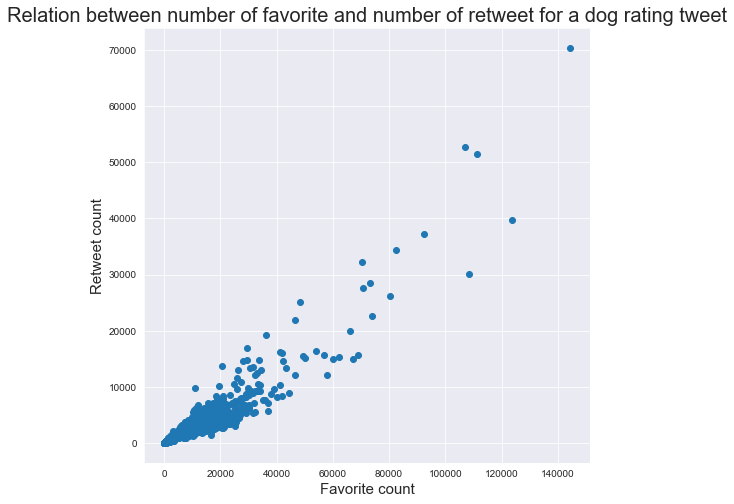

In [97]:
plt.figure(figsize=(8,8));
plt.scatter(df_tweet_merge["favorite_count"],df_tweet_merge["retweet_count"]);
plt.title("Relation between number of favorite and number of retweet for a dog rating tweet",fontsize=20);
plt.xlabel("Favorite count",fontsize=15);
plt.ylabel("Retweet count",fontsize=15);

This figure suggest that number of retweet and favorite count are proportionally related. Number of favorite grow with number of retweet.